In [1]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
from scipy.linalg import block_diag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from custom_kernels import Changepoint
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD
from data_utils import log_full_spline

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [16]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

In [17]:
# load in data from the pickled files
import pickle

In [21]:
with open('../data/pickled_data/NSM_changepoint_data_20n0_0_True_nsat.pkl', 'rb') as fp:
    density20cut = pickle.load(fp)
    pressure20cut = pickle.load(fp)  # automatically in order of saving
    edens20cut = pickle.load(fp)
    cs220cut = pickle.load(fp)
    
with open('../data/pickled_data/NSM_changepoint_data_20n0_0_True.pkl', 'rb') as fp:
    density20 = pickle.load(fp)
    pressure20 = pickle.load(fp)  # automatically in order of saving
    edens20 = pickle.load(fp)
    cs220 = pickle.load(fp)

In [42]:
# plot the unscaled version of the pressure here
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
gp_cs2_convert_arr = convert_interp(density20)
gp_cs2_convert_cut_arr = convert_interp(density20cut)

In [52]:
# convert pressures
pressure20scaled = pressure20['mean'] / gp_cs2_convert_arr
pressure20stdscaled = pressure20['std'] / gp_cs2_convert_arr
pressure20cutscaled = pressure20cut['mean'] / gp_cs2_convert_cut_arr
pressure20cutstdscaled = pressure20cut['std'] / gp_cs2_convert_cut_arr

In [53]:
# get the pqcd curve to only plot greater than the cutoff choice
cutoff = 20
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

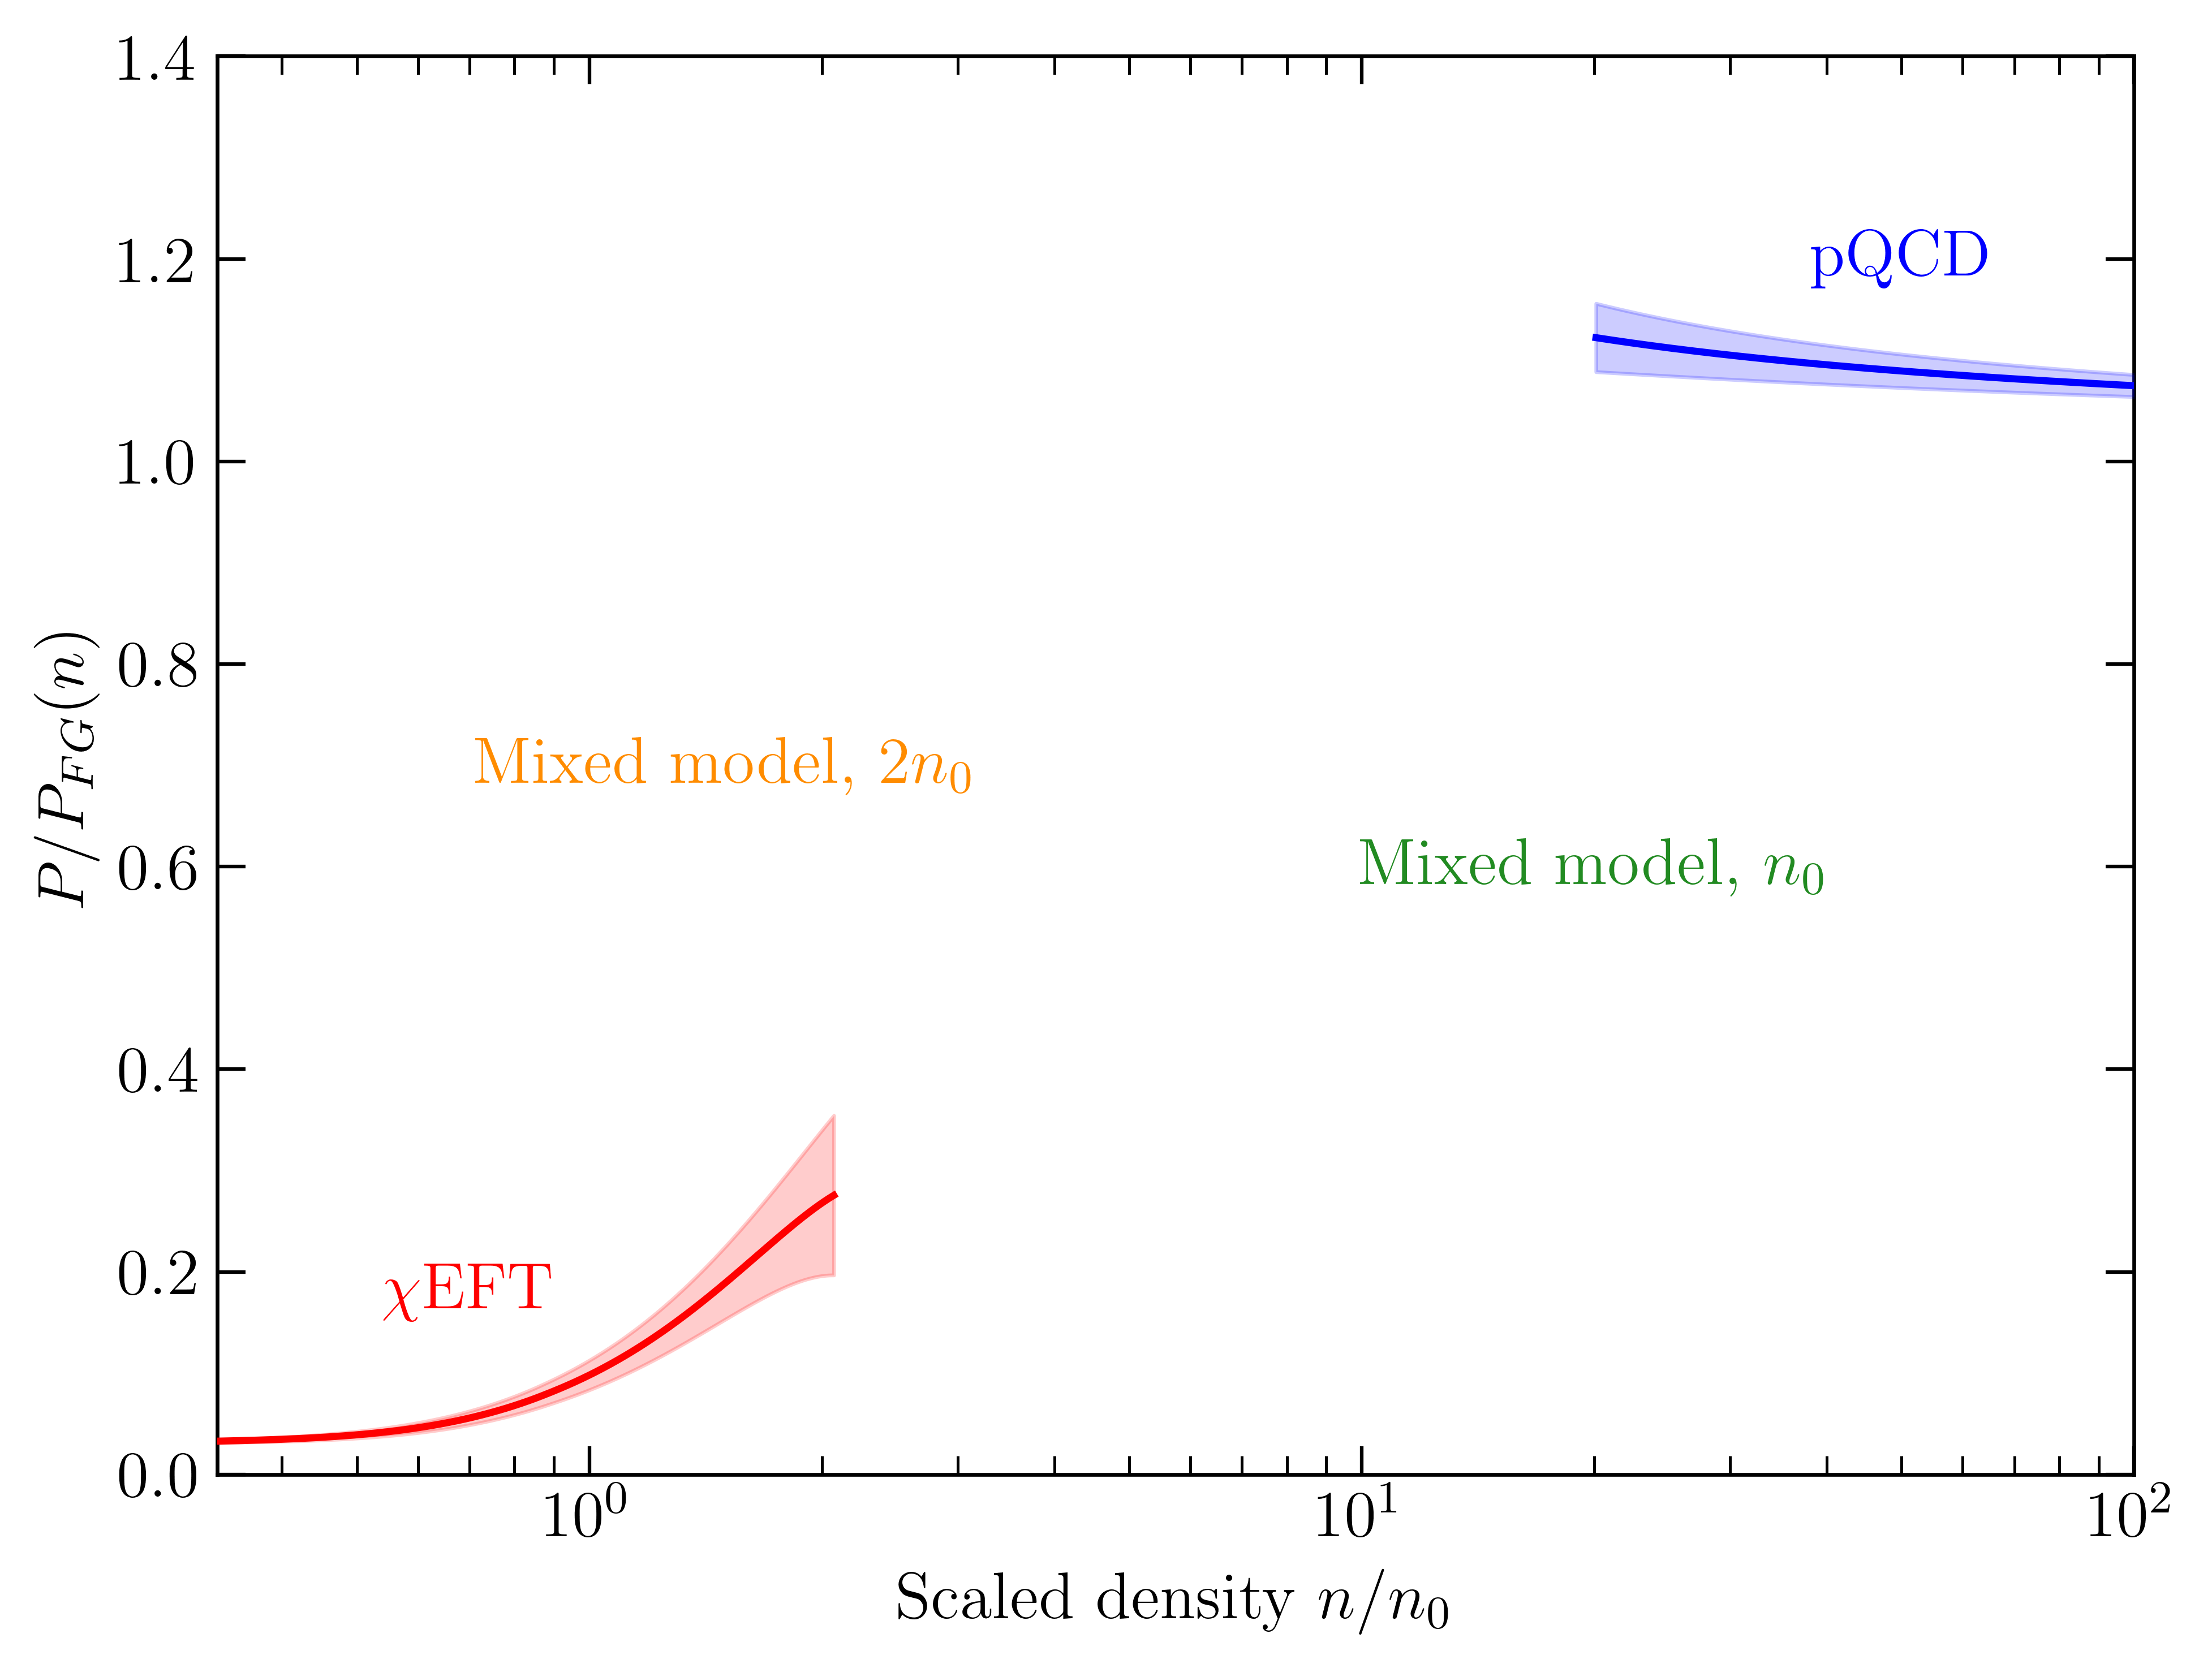

In [56]:
# plot these as a comparison between the two cutoffs
fig, ax = plt.subplots(1,1, dpi=600)

# check the plotting of both of these together, see what they look like
ax.tick_params(which='major', labelsize=14, right=True, top=True, length=6)
ax.tick_params(which='minor', right=True, top=True, length=4)

ax.plot(data_xeft['density']/n0, data_xeft['mean'], color='red', zorder=10)
ax.fill_between(data_xeft['density']/n0, data_xeft['mean']-data_xeft['std_dev'], data_xeft['mean']+data_xeft['std_dev'], \
                alpha=0.2, color='red', zorder=9)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', zorder=10)
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color='blue', \
                zorder=9)

# n0
ax.plot(density20cut/n0, pressure20cutscaled, color='forestgreen', zorder=8)
ax.fill_between(density20cut/n0, pressure20cutscaled-pressure20cutstdscaled, \
                pressure20cutscaled+pressure20cutstdscaled, alpha=0.2, color='forestgreen', zorder=7)

# 2n0
ax.plot(density20/n0, pressure20scaled, color='darkorange', zorder=6)
ax.fill_between(density20/n0, pressure20scaled-pressure20stdscaled, \
                 pressure20scaled+pressure20stdscaled, alpha=0.2, \
                color='darkorange', zorder=5)

# some labelling for fun times
ax.text(0.7, 0.18, r'$\chi$EFT', va='center', ha='center', fontsize=14, color='red')
ax.text(50.0, 1.2, r'pQCD', va='center', ha='center', fontsize=14, color='blue')
ax.text(1.5, 0.7, r'''Mixed model, $2n_{0}$''', \
        va='center', ha='center', multialignment='center', fontsize=14, color='darkorange')
ax.text(20.0, 0.6, r'''Mixed model, $n_{0}$''', va='center', ha='center', \
        multialignment='center', fontsize=14, color='forestgreen')

# other things
ax.set_xscale('log')
ax.set_xlabel('Scaled density $n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P/P_{FG}(n)$', fontsize=14)
ax.set_xlim(0.33, 100.0)
ax.set_ylim(0.0, 1.4)
plt.show()